# Métricas para Clasificación

Evaluar correctamente el rendimiento de un modelo de clasificación es fundamental para entender su comportamiento y utilidad en contextos reales.

Más allá de la exactitud (accuracy), existen métricas más informativas cuando se trabaja con clases desbalanceadas o cuando ciertos errores son más costosos que otros.

Entre las métricas más comunes se encuentran la precisión (precision), que indica la proporción de verdaderos positivos sobre los predichos como positivos; la recuperación (recall), que mide la proporción de verdaderos positivos sobre los realmente positivos; y la F1-score, que armoniza precisión y recall.

También es útil el área bajo la curva ROC (AUC-ROC) para evaluar la capacidad de discriminación del modelo. Elegir la métrica adecuada depende del problema específico y de los objetivos del análisis.

Carguemos las librerías necesarias para aplicar las métricas a un modelo específico.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

Carguemos el dataset a utilizar.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/titanic-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/titanic-dataset


In [ ]:
df = pd.read_csv(path + "/Titanic-Dataset.csv")

En este caso, nuestra variable objetivo será Survived (si sobrevivió o no).

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Recordemos que este dataset tenia ciertos problemas.

Separemos las variables que vimos, anteriormente, que eran relevantes al momento de decidir si una persona sobrevivió o no.

In [ ]:
num = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat = ['Sex', 'Embarked']

Verifiquemos la existencia de nulos en el dataset.

In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Notemos que la variable Cabin tiene un porcentaje bien alto de nulos, la sacaremos ya que no aporta información que representa.

Las variables de Age y Embarked si las dejaremos y haremos una corrección para utilizarlas.

In [ ]:
# Eliminamos la columna Cabin
df.drop('Cabin', axis=1, inplace=True)

# Cambiamos los nulos por la mediana en Age, debido a que son valores enteros.
df['Age'].fillna(df['Age'].median(), inplace=True)

# Cambiamos los nulos por la moda en Embarked, debido a que son valores
# categoricos.
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

<ipython-input-8-371a046331f1>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-8-371a046331f1>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Visualicemos si ya corregimos los nulos.

In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


Ahora queremos mirar que tan desbalanceadas están las clases.

<Axes: ylabel='Frequency'>

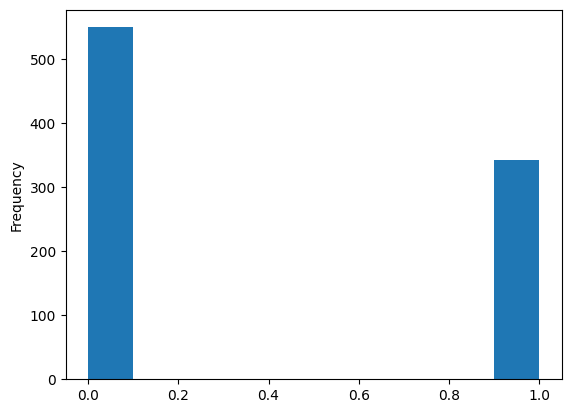

In [ ]:
df['Survived'].plot(kind='hist')

Notemos que están desbalanceadas pero no al nivel de representar una complicación.

Luego de lo anterior, procedamos a implementar la Logistic Regression.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df[num + cat]
y = df['Survived']

Para poder realizar la separacion de los datos tenemos que decirle que es un problema de clasificación.

Por lo tanto se va a estratificar la selección de las variables en y, esto quiere decir que va a mantener en el conjunto de train y de test el porcentaje de cada clase tal cual viene en el modelo original.


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

La regresion logistica, al igual que la regresion lineal, necesita que las variables estén estandarizadas.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Realicemos el preprocesamiento. Recordemos que si hay muchos outliers ocupamos RobustScaler en vez de StandardScaler.

In [ ]:
prep = ColumnTransformer([
    ('num', RobustScaler(), num),
    ('cat', OneHotEncoder(), cat)
])

Construyamos el pipeline del modelo, primero sin balancear.

In [ ]:
logistic_reg = Pipeline([
    ('prep', prep),
    ('logi_reg', LogisticRegression(random_state=42, # Semilla
                                    max_iter=1000, # Maximo de iteraciones
                                    solver='liblinear', # Metodo de optimizacion
                                    penalty = 'l1', # Funcion de penalizacion
                                    C = 0.1 # Parametro de regularizacion
                                    ))
])

Entrenamiento.

In [ ]:
logistic_reg.fit(X_tr, y_tr)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Embarked'])])),
                ('logi_reg',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

Realización de las predicciones y evaluación de las métricas a las mismas para analizar el rendimiento del modelo.

In [ ]:
pred_logis = logistic_reg.predict(X_te)

# Acurracy: Aciertos totales (TP+TN/n)
print('Acurracy :',accuracy_score(y_te, pred_logis))

# Precision: De todos los positivos que predije, cuantos fueron realmente
# positivos (TP/TP+FP)
print('Precision :',precision_score(y_te, pred_logis))

# Recall: De todos los positivos reales, cuantos fui capaz de predecir como
# positivos (TP/TP+FN)
print('Recall :',recall_score(y_te, pred_logis))

# f1_score: Media armonica entre precision y recall
print('f1_score',f1_score(y_te, pred_logis))

# roc_auc_score: Area bajo la curva ROC, mide la capacidad del modelo para
# distinguir entre clases
print('roc_auc_score',roc_auc_score(y_te, pred_logis))

Acurracy : 0.7932960893854749
Precision : 0.7758620689655172
Recall : 0.6521739130434783
f1_score 0.7086614173228346
roc_auc_score 0.76699604743083


Los valores de las metricas antes calculadas en este caso del Titanic expresan que:

- Que la Acurracy sea cercana a 1 expresa un mayor acierto de los casos.
- Que la Precision sea cercana a 1 expresa un menor numero de casos en donde se predice que sobrevivió cuando en realidad murió.
- Que el Recall sea cercano a 1 expresa un menor numero de casos en donde se predice que murió cuando en realidad sobrevivió.

Ahora, probaremos el modelo Logistic Regression pero balanceado. Esto lo que hace es desechar datos de la clase mayor representada para tener el mismo número de datos en ambas clases y luego hacer el entrenamiento.

In [ ]:
logistic_reg_balanced = Pipeline([
    ('prep', prep),
    ('logi_reg', LogisticRegression(random_state=42, # Semilla
                                    max_iter=1000, # Maximo de iteraciones
                                    solver='liblinear', # Metodo de optimizacion
                                    penalty = 'l1', # Funcion de penalizacion
                                    C = 0.1, # Parametro de regularizacion
                                    class_weight='balanced' # Balanceo de clases
                                    ))
])

Entrenamiento.

In [ ]:
logistic_reg_balanced.fit(X_tr, y_tr)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Embarked'])])),
                ('logi_reg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

Predicción del modelo y evaluación del mismo a través de las métricas.

In [ ]:
# Prediccion

pred_logis_balanced = logistic_reg_balanced.predict(X_te)

# Metricas

print('Acurracy :',accuracy_score(y_te, pred_logis_balanced))
print('Precision :',precision_score(y_te, pred_logis_balanced))
print('Recall :',recall_score(y_te, pred_logis_balanced))
print('f1_score',f1_score(y_te, pred_logis_balanced))
print('roc_auc_score',roc_auc_score(y_te, pred_logis_balanced))

Acurracy : 0.7988826815642458
Precision : 0.72
Recall : 0.782608695652174
f1_score 0.75
roc_auc_score 0.7958498023715415


Etiquetas de las predicciones.

In [ ]:
pred_logis_balanced

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0])

Lo siguiente nos dará las probabilidades de cada clase con las que asigno la variables de test.

Se interpreta como las probabilidades predichas por el modelo de regresión logística balanceada de que cada instancia en el conjunto de prueba (X_te) pertenezca a la clase positiva.

Cuando decimos que predict_proba devuelve las probabilidades para cada "instancia" en X_te, nos referimos a que proporciona la probabilidad de supervivencia para cada persona individual en el conjunto de prueba.

In [ ]:
logistic_reg_balanced.predict_proba(X_te)[:,1]

array([0.16970289, 0.13921943, 0.22913051, 0.11581247, 0.65999707,
       0.59264507, 0.7856258 , 0.4456927 , 0.47509612, 0.29136808,
       0.20457726, 0.19602367, 0.66920956, 0.33556063, 0.67176328,
       0.21673317, 0.57845359, 0.18906538, 0.23313445, 0.7937242 ,
       0.18906538, 0.81450161, 0.18170194, 0.60059368, 0.18527526,
       0.93458878, 0.20457726, 0.41264723, 0.20070917, 0.20790891,
       0.16764813, 0.94630973, 0.18630602, 0.2003415 , 0.24823961,
       0.26882874, 0.27788333, 0.59773264, 0.20457726, 0.85038677,
       0.30326469, 0.9611069 , 0.24406273, 0.85251138, 0.79370589,
       0.21656488, 0.18974076, 0.56299817, 0.76854125, 0.82377787,
       0.91629789, 0.66387465, 0.68533717, 0.34459392, 0.82837922,
       0.19665552, 0.17211962, 0.5062338 , 0.70058211, 0.51252615,
       0.65928754, 0.78204885, 0.23787922, 0.26070081, 0.51914925,
       0.66298052, 0.92142912, 0.17170283, 0.35647474, 0.36694173,
       0.81708026, 0.2043182 , 0.6854162 , 0.94308381, 0.31712

Ahora, haremos una nueva prediccion donde cambiaremos la funcion de penalizacion, ya que en algunos casos la funcion 'l2' suele entregar mejores resultados.

In [ ]:
logistic_reg_balanced_l2 = Pipeline([
    ('prep', prep),
    ('logi_reg', LogisticRegression(random_state=42, # Semilla
                                    max_iter=1000, # Maximo de iteraciones
                                    solver='liblinear', # Metodo de optimizacion
                                    penalty = 'l2', # Funcion de penalizacion
                                    C = 0.1, # Parametro de regularizacion
                                    class_weight='balanced' # Balanceo de clases
                                    ))
])

Entrenamiento.

In [ ]:
logistic_reg_balanced_l2.fit(X_tr, y_tr)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Embarked'])])),
                ('logi_reg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

Realicemos la predicción del modelo y evaluemoslo a través de las métricas.

In [ ]:
# Prediccion

pred_logis_balanced_l2 = logistic_reg_balanced_l2.predict(X_te)

# Metricas

print('Acurracy :',accuracy_score(y_te, pred_logis_balanced_l2))
print('Precision :',precision_score(y_te, pred_logis_balanced_l2))
print('Recall :',recall_score(y_te, pred_logis_balanced_l2))
print('f1_score',f1_score(y_te, pred_logis_balanced_l2))
print('roc_auc_score',roc_auc_score(y_te, pred_logis_balanced_l2))

Acurracy : 0.7877094972067039
Precision : 0.7066666666666667
Recall : 0.7681159420289855
f1_score 0.7361111111111112
roc_auc_score 0.7840579710144927


En este caso, en el conjunto balanceado el porcentaje de aciertos fue mejor utilizando l1 que utilizando l2.

Ahora, procederemos a ver la **curva ROC-AUC**.

La Curva ROC (Receiver Operating Characteristic) es una herramienta gráfica que se utiliza para evaluar el rendimiento de un modelo de clasificación binaria.

Se traza graficando la Tasa de Verdaderos Positivos (True Positive Rate - TPR) en el eje y contra la Tasa de Falsos Positivos (False Positive Rate - FPR) en el eje x en varios umbrales de clasificación.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
y_pred_proba = logistic_reg_balanced.predict_proba(X_te)[:, 1]

Visualicemos el gráfico de la curva.

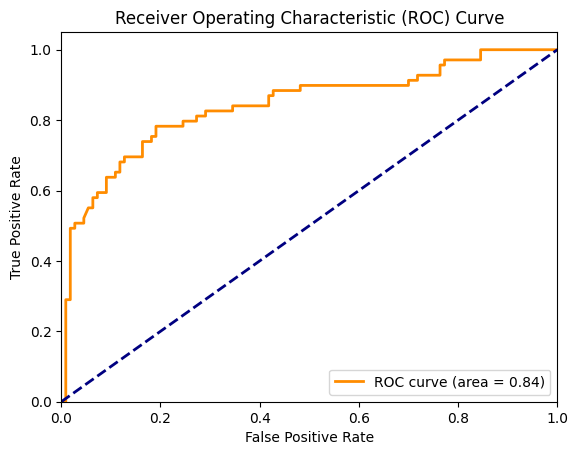

In [ ]:
fpr, tpr, thresholds = roc_curve(y_te, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Notemos que la linea punteada representa la predicción al azar de las clases y nuestra curva está bastante más sobre la linea de la media. El área bajo la curva es del 84%.

La línea que se traza en el gráfico representa el rendimiento del modelo en diferentes umbrales de decisión. Cada punto en la curva corresponde a un umbral diferente. Al variar el umbral, se cambia la proporción de falsos positivos y verdaderos positivos.

La línea azul representa un clasificador aleatorio. Un modelo cuya curva ROC se encuentra cerca de esta línea tiene un rendimiento cercano al azar.

En el código, cuando calculas logistic_reg_balanced.predict_proba(X_te)[:, 1], obtienes las probabilidades de supervivencia para cada pasajero en el conjunto de prueba.

La función roc_curve luego utiliza estas probabilidades y compara los resultados con los valores reales (y_te) en diferentes umbrales para calcular los puntos (FPR, TPR) que forman la curva ROC.

In [ ]:
y_pred = logistic_reg_balanced.predict(X_te)

Con lo siguiente veremos como se comportan las metricas en las diferentes clases, en este caso sobrevivió (1) o no sobrevivió (0).


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       110
           1       0.72      0.78      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.80      0.80      0.80       179

